# Super Resolution using Perceptual Loss

Based on "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Johnson et.al
http://arxiv.org/abs/1603.08155


## **General Concept**

1 upsampling network to take image from loRes to HiRes  
1 vgg to get activations on ground truth hires image (not trainable)  using block2_conv2  
1 vgg to get activation on image made by upsampling (not trainable)  basically same network as above  
take MSE loss of each vgg  
optimize the upsampling network to reduce the combined loss  
target for loss so make it zeros  

finalmodel (lowres, vgg, loss)

input  lowRes photo  ->  CNN   -> HiRes photo output  
loss function calculates the content loss between loRes and hiRes  
perceptual loss = MSE between activations of 2 images 

can use for denoising, SR, colorization (grayscale -> color)  
Generative Image  = Image In -> Image Out

fitting 
Keras needs to match a loss to target so make an array of zeros
compile with adam and mse

Eventually the only model we care about is our upsampling model

## Architecture

inp = Input(inp_shape)  
x = conv_block(inp,64,9,(1,1)  - this is 1x1 convolutions creating 64 filters, filter size=9 - this allows us to increase the receptive field  - common in modern CNNs (stride 1,1) doesn't through away any info

4 res_block - the computation this is the key work. 
resnet 2 convs on the input then adds that back to the original (no activation on last conv)

In generative models we want to do the computation at a low level
 - at low level there is less work to do so its faster
 - at low level we have a bigger receptive field so we can recognize stuff fast - eg. 3x3 give 3x3 recptive field depending on how deep you are
 - down sampling can increase receptive field
 
 conv_block = Conv + BatchNorm + activation

### Imports

In [2]:
%matplotlib inline

import numpy as np

from PIL import Image
import os
import sys
import bcolz
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras_tqdm import TQDMNotebookCallback
from keras import initializations
from keras.applications.resnet50 import ResNet50, decode_predictions, conv_block, identity_block
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions, preprocess_input

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
import keras.backend as K

from vgg16_avg import VGG16_Avg

### SDK Versions


In [3]:
print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)


TensorFlow: 1.0.1
Keras: 1.2.2


## Celeb Faces Data

Download the dataset at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

then convert to a bcolz array

In [4]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [6]:
# change to your dir path
#dpath = '/home/gpuserver/non_trading_models/ai_learning/Key_DL_Learning'

# Loading the premade bcolz arrays
bcolz_hr = '/celeba-176_2k.bc'
bcolz_lr = '/celeba-44_2k.bc'
bcolz_elr = '/celeba-22_2k.bc'
bcolz_test_lr = '/celeba-44_test.bc'
bcolz_test_hr = '/celeba-176_test.bc'

arr_hr = load_array(dpath+bcolz_hr)
arr_lr = load_array(dpath+bcolz_lr)
arr_test_hr = load_array(dpath+bcolz_test_hr)
arr_test_lr = load_array(dpath+bcolz_test_lr)

arr_lr.shape

(2000, 44, 44, 3)

### Image Preprocessing for VGG16 Model

In [7]:
# vgg preproc
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]


### Set up Network parts

ConvBlock  
ResBlock
    - no activation on the last layer

In [8]:
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(num_filters, filter_size, filter_size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

def res_block(initial_input, num_filters=64):
    x = conv_block(initial_input, num_filters, 3, (1,1))
    x = conv_block(x, num_filters, 3, (1,1), act=False)
    return merge([x, initial_input], mode='sum')

Deconvolution / Transposed Conv / Fractionally Strident Convs

filter size of 9 increases the receptive field of layers  
1 large filter right at the start is common in many modern networks nowadays  
stride 1x1 is so we don't throw away any information at this stage - we keep the full image size no downsample  


In [9]:
# Up Sampling block aka deconvolution
def up_block(x, num_filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(num_filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

### Set up Upsampling network

In [10]:
def get_upsampling_model_4x(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x) # this restores to a normal image
    return inp,outp

### Notes

1x1 convs with large 9 lets us have a larger receptive field  

The Tanh gets us between -1,1    
+1 * 127.5 gets the 0-255 back

In [11]:
# this gets the output 
upsampled_inp,upsampled_output = get_upsampling_model_4x(arr_lr) 
# we define the tensor sizes by giving it the example tensor

In [12]:
up_model2 = Model(upsampled_inp,upsampled_output)
up_model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 44, 44, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 44, 44, 64)    15616       input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 44, 44, 64)    256         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 44, 44, 64)    0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

### VGG16 network

this is only used to for creating the feature outputs from the images that we use for calculating our loss


In [13]:
#vgg input 
vgg_inp=Input(arr_hr.shape[1:])

#vgg network
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False  # can't have loss function be trainable

In [14]:
# Lambda makes a layer of a function/ this makes the preprocessing a layer
# This preprocesses our normal images to make them ready for VGG 
preproc_layer = Lambda(preproc)

In [15]:
# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

vgg_content.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 176, 176, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 176, 176, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 88, 88, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [16]:
vgg_content.output_shape

(None, 88, 88, 128)

** We have gone from (176,176,3 )   to   (88,88,128) **
   
      
         
.

## We make two versions of the VGG one for Orig, one for Up Sample

In [48]:
# this is the VGG model with the HR input
vgg_hr_image = vgg_content(preproc_layer(vgg_inp))

# this is the upsampled network
vgg_upsampled_output = vgg_content(preproc_layer(upsampled_output))

### Loss and Optimisers & putting it all into 1 model


In [49]:
# Mean Sum of Squared Errors on the outputs of the 2 VGG nets
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_upsampled_output])

In [50]:
super_res_model = Model([upsampled_inp, vgg_inp], loss)
super_res_model.compile('adam', 'mse')

### Training

In [ ]:
# we need a target for the network to train to
targ = np.zeros((arr_hr.shape[0], 128))


# fit the model
super_res_model.fit([arr_lr, arr_hr], targ, 8, 10)

Epoch 1/10
1488/2000 [=====================>........] - ETA: 19s - loss: 36816.1347

### Saver & Loader


In [19]:
it_model = Model(upsampled_inp, upsampled_output)
it_model.save_weights('./weights/'+'celba_2k.h5')

In [51]:
it_model = Model(upsampled_inp, upsampled_output)
it_model.load_weights('./weights/'+'celba_2k.h5')

### Examples

show 1. low res 2. hi-res 3. ground truth


In [52]:
%time p = it_model.predict(arr_lr[0:50])
p.shape

CPU times: user 1min 8s, sys: 12.9 s, total: 1min 21s
Wall time: 16.6 s


(50, 176, 176, 3)

In [53]:
def compare_pics(x,y):
    fig = plt.figure(figsize=(30,30))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(x)
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(y)

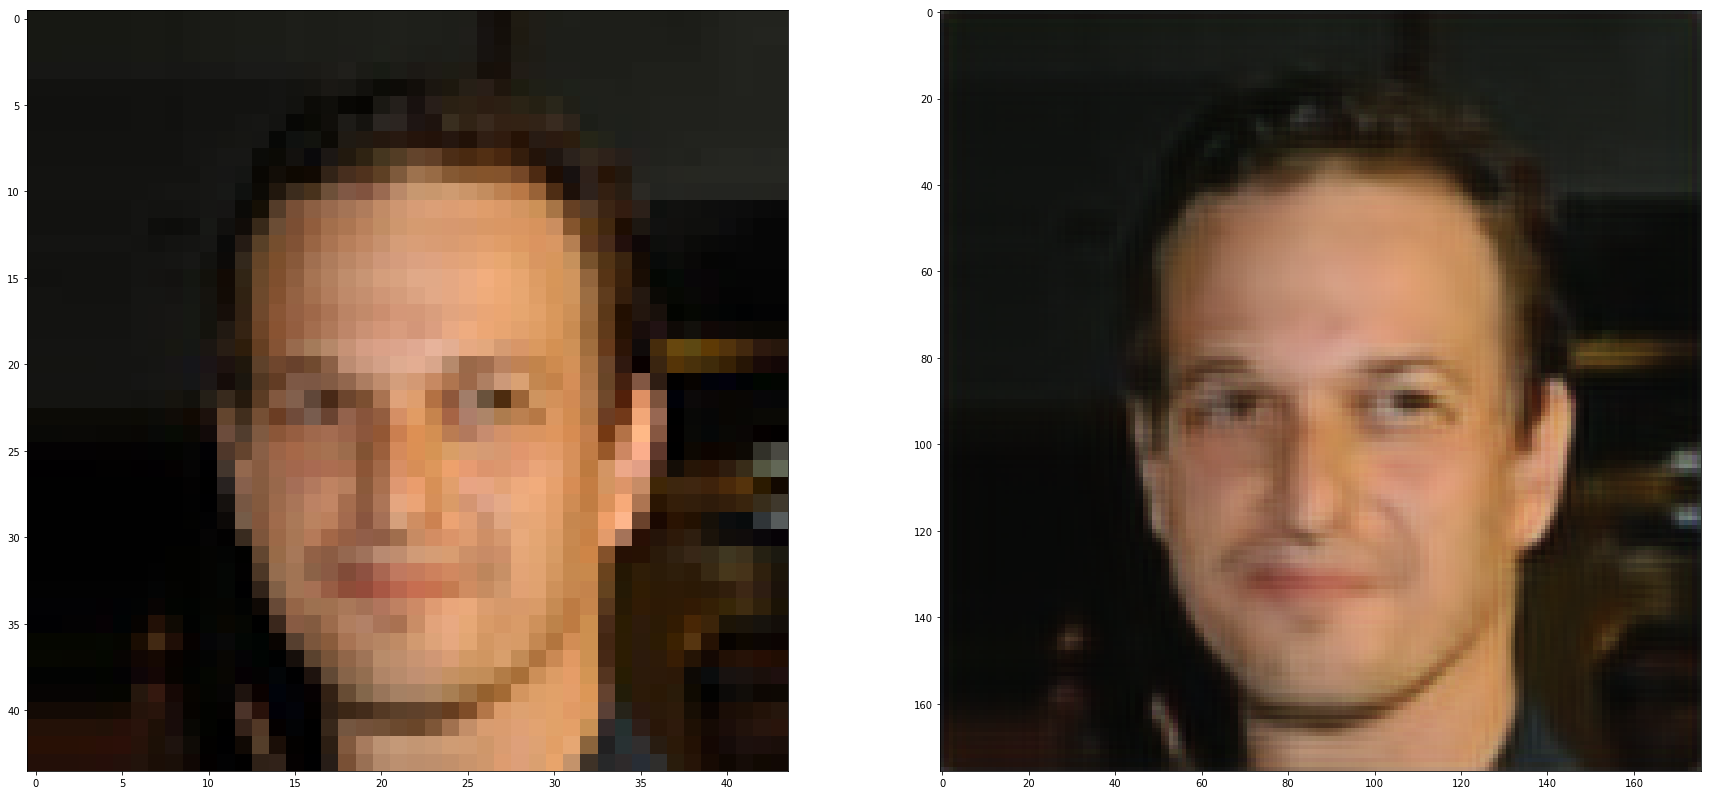

In [54]:
compare_pics(arr_lr[15].astype('uint8'), p[15].astype('uint8'))

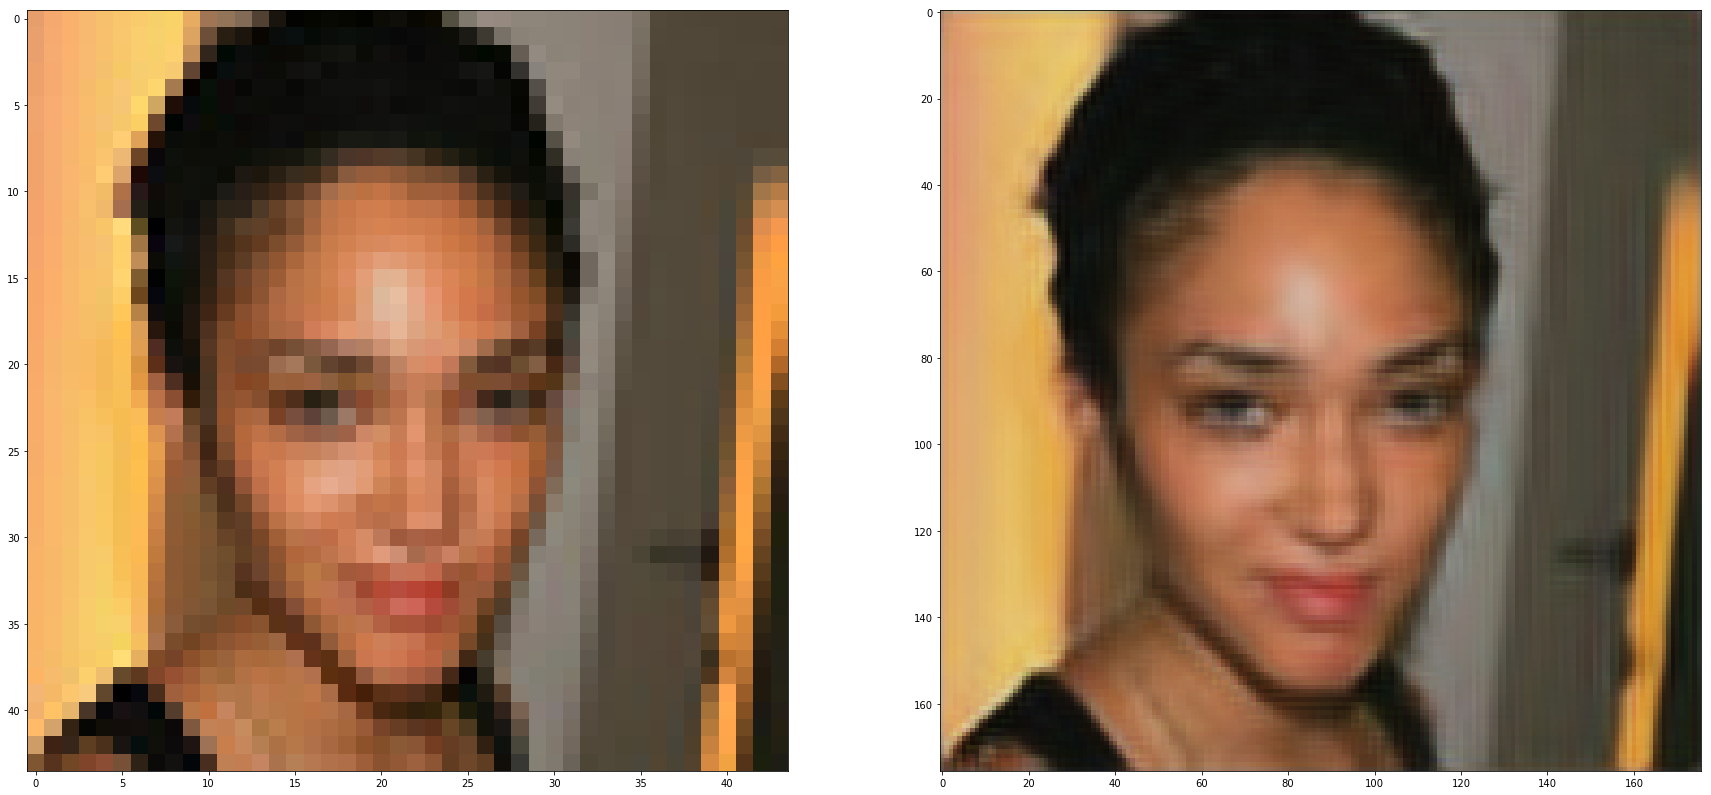

In [25]:
compare_pics(arr_lr[13].astype('uint8'), p[13].astype('uint8'))

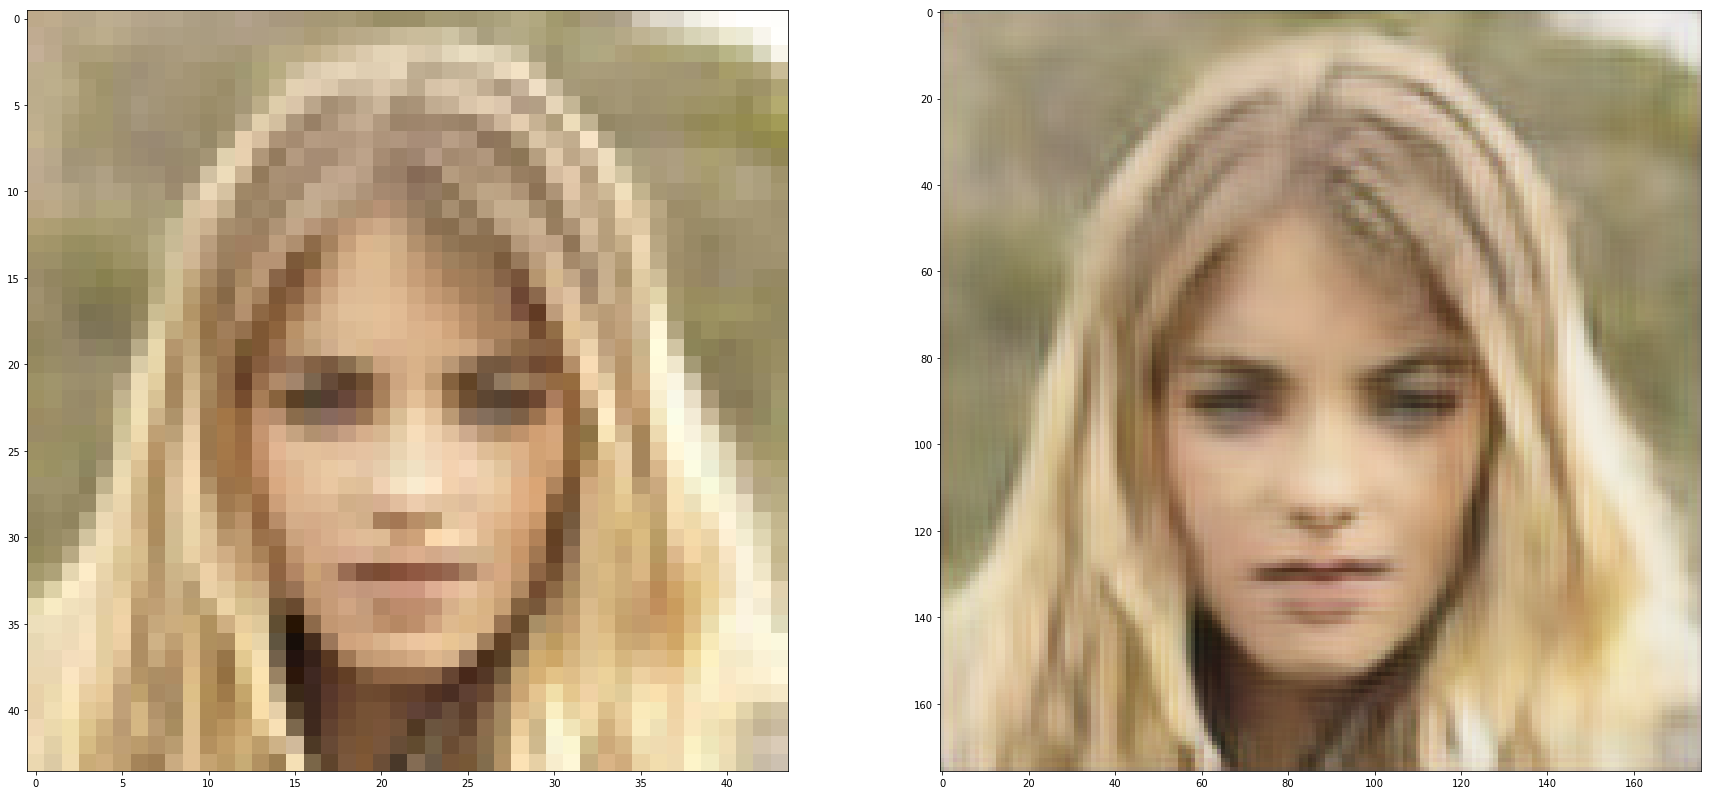

In [26]:
compare_pics(arr_lr[18].astype('uint8'), p[18].astype('uint8'))

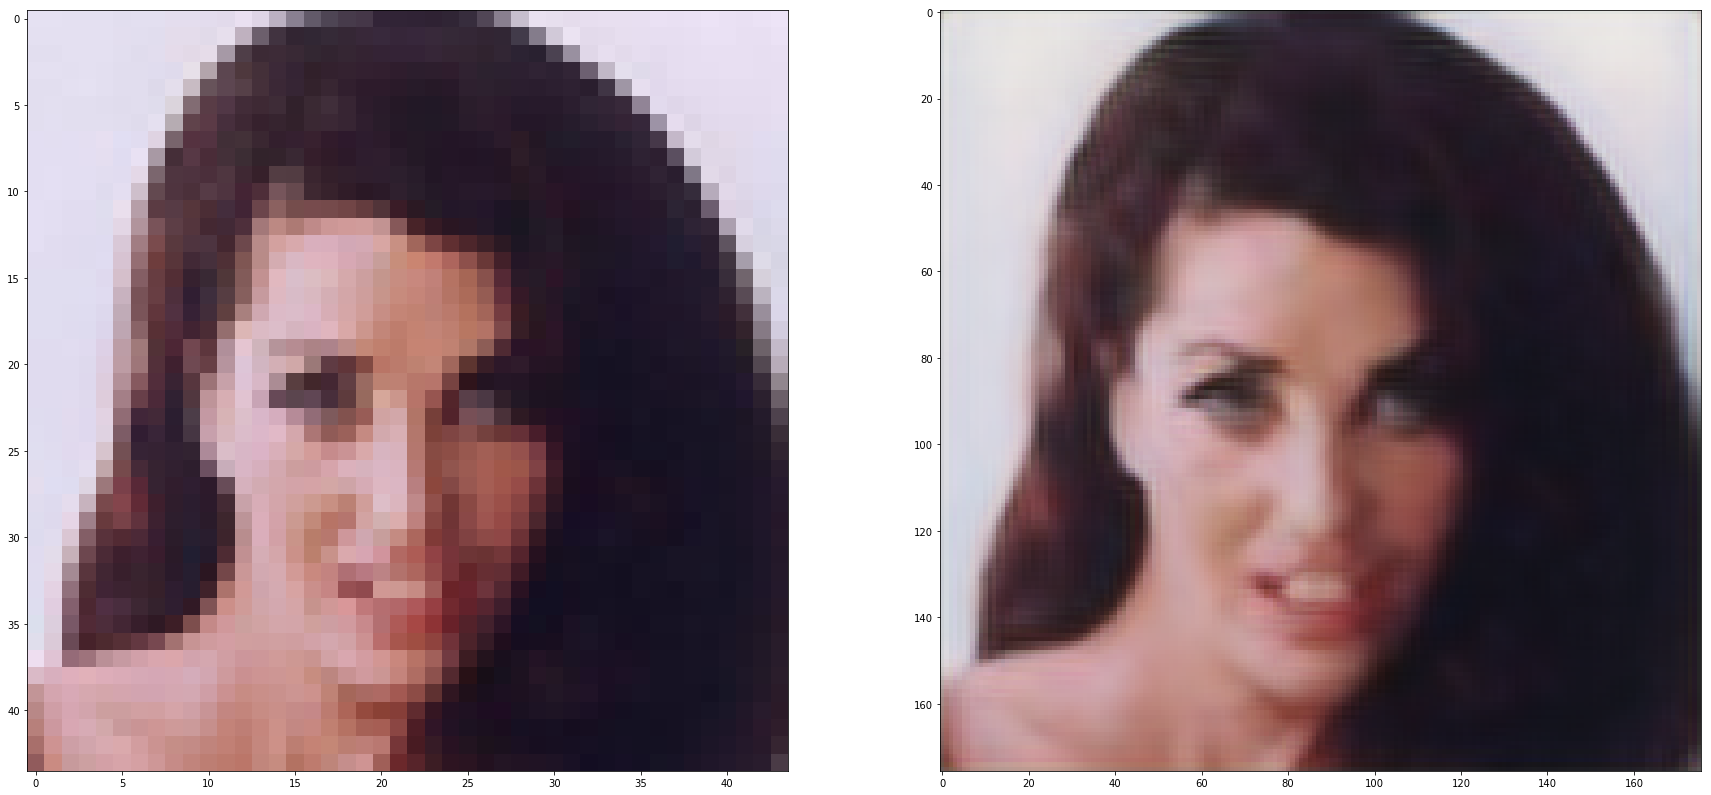

In [29]:
compare_pics(arr_lr[10].astype('uint8'), p[10].astype('uint8'))

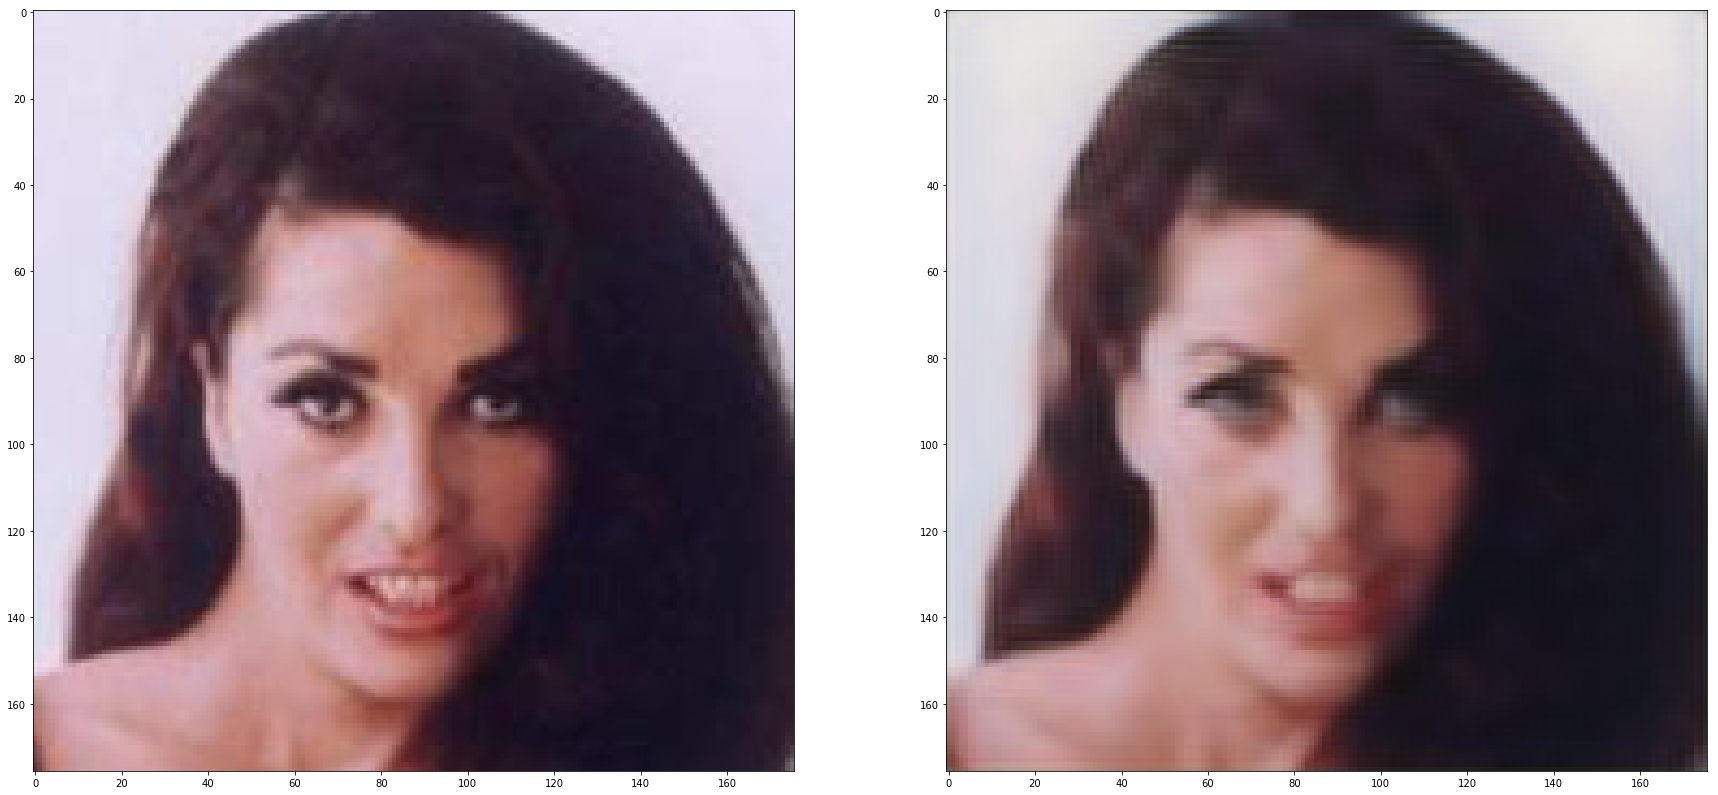

In [28]:
compare_pics(arr_hr[10].astype('uint8'),p[10].astype('uint8'))

# Predicting on Test set that the model hasn't seen

In [30]:
% time p = it_model.predict(arr_test_lr[0:40])
p.shape

CPU times: user 50.1 s, sys: 8.99 s, total: 59.1 s
Wall time: 11.2 s


(40, 176, 176, 3)

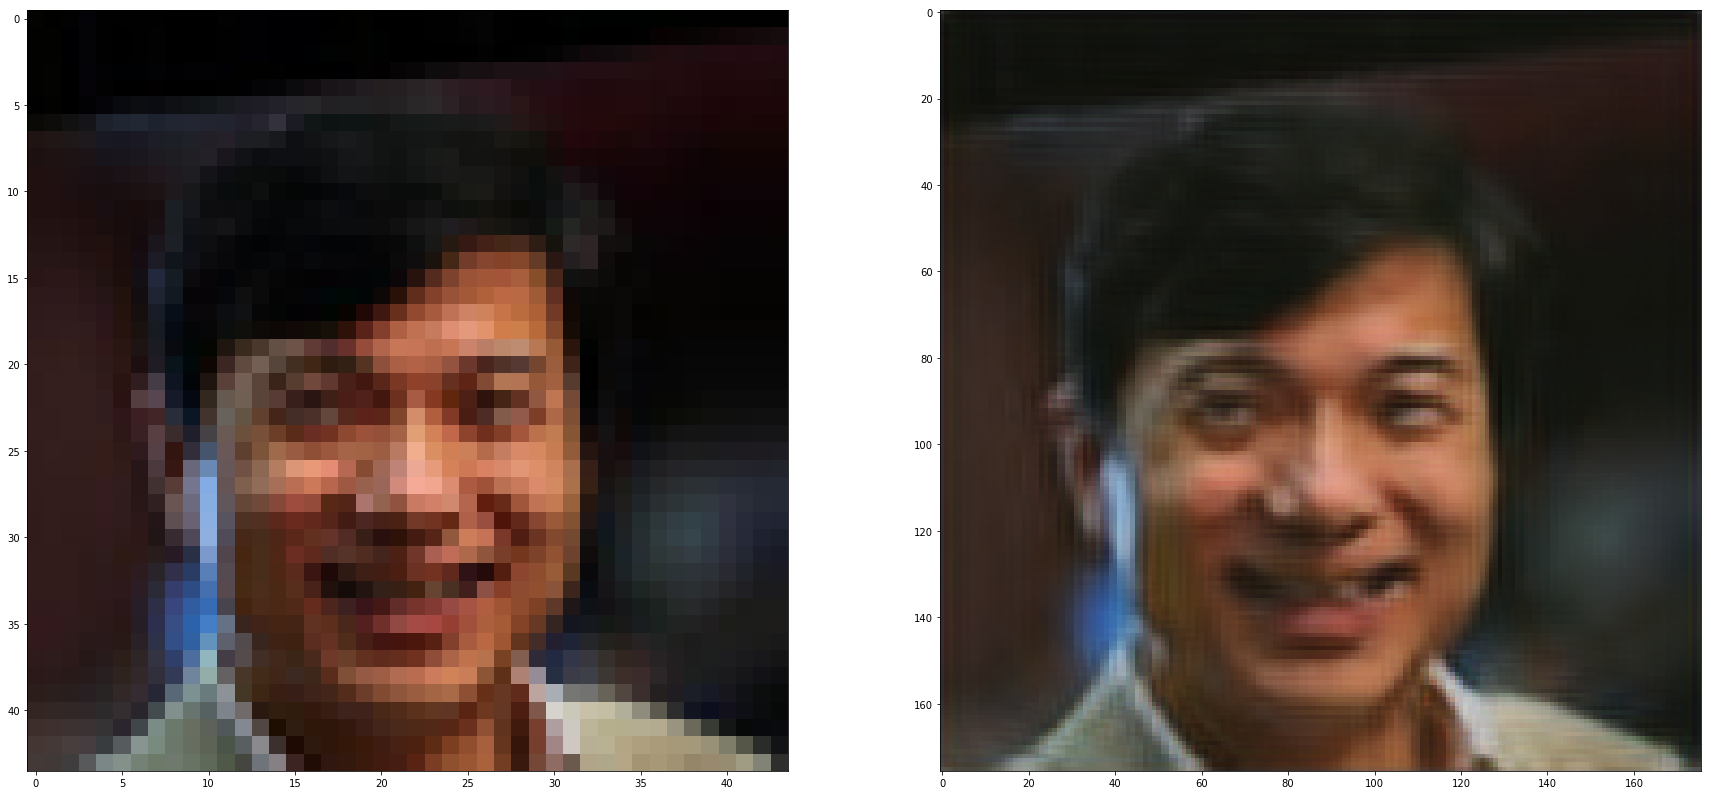

In [31]:
compare_pics(arr_test_lr[29].astype('uint8'),p[29].astype('uint8'))

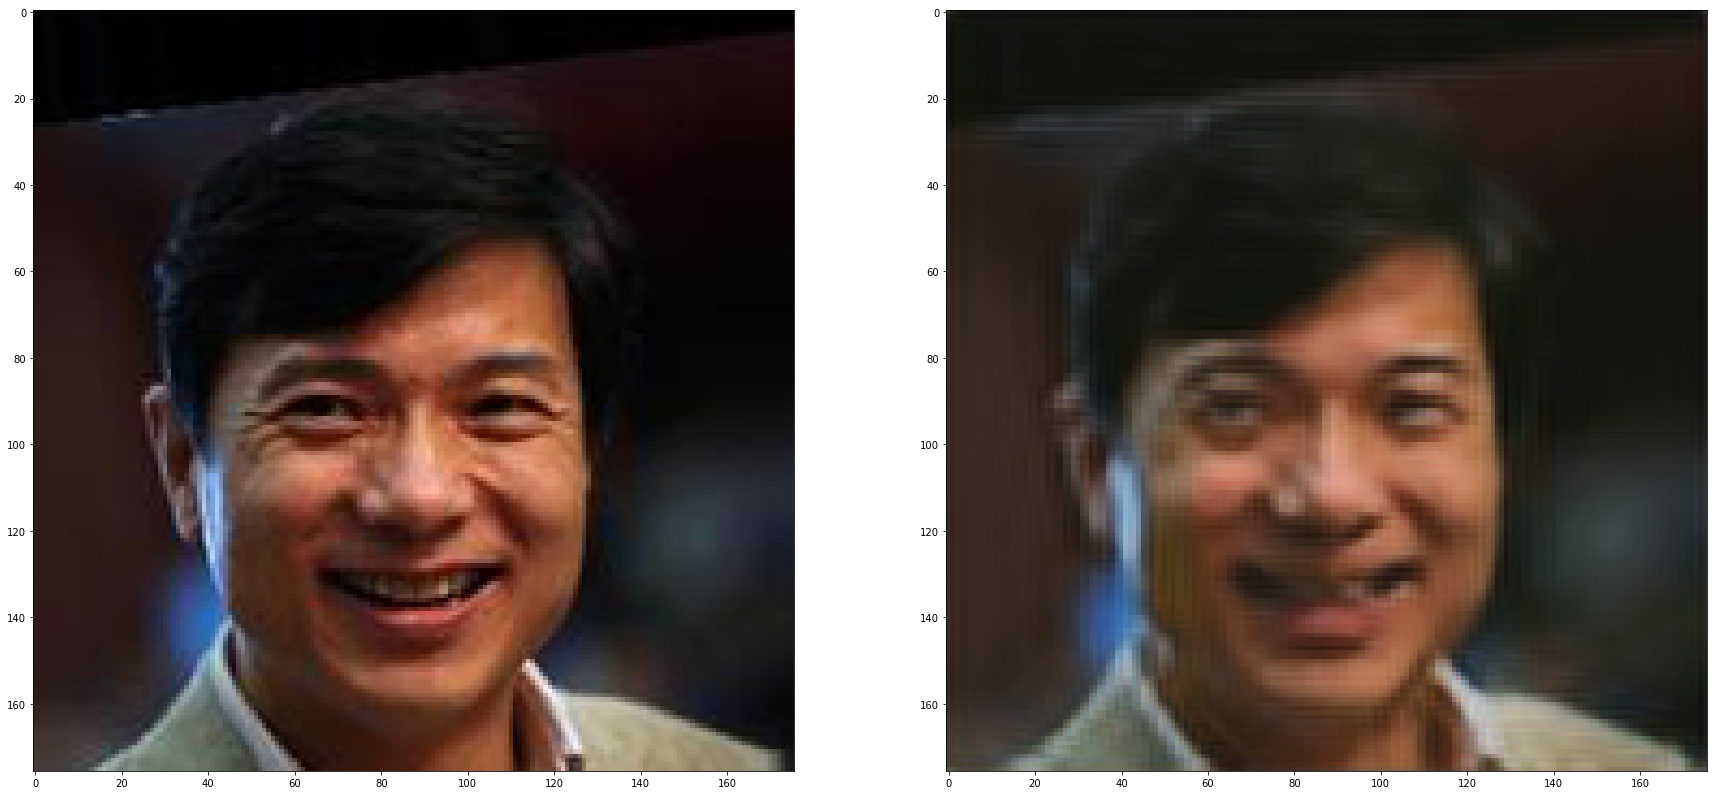

In [33]:
compare_pics(arr_test_hr[29].astype('uint8'),p[29].astype('uint8'))

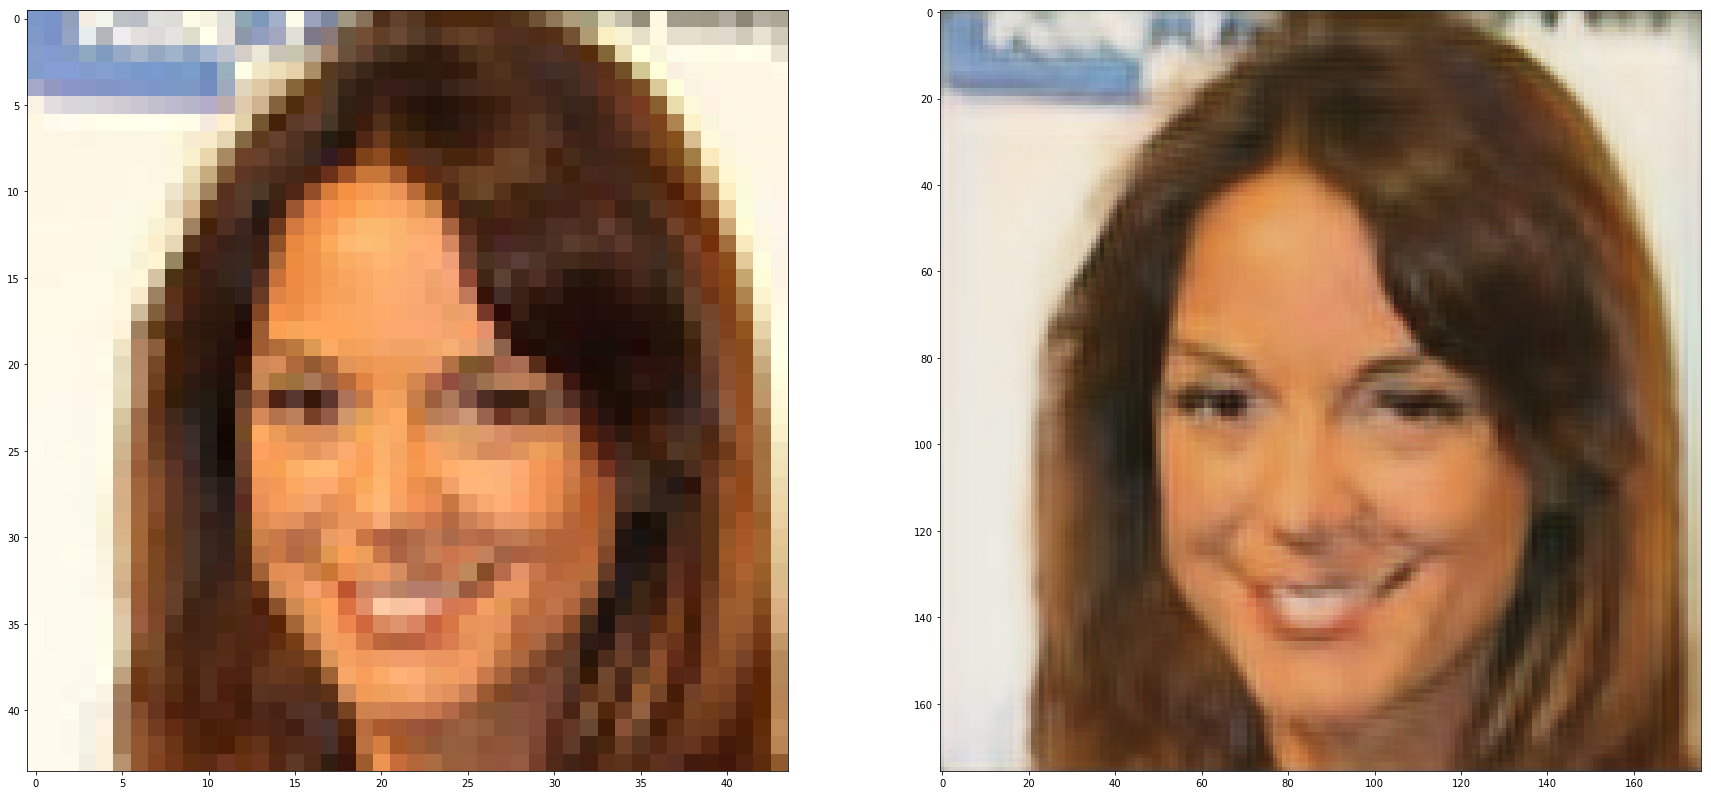

In [34]:
compare_pics(arr_test_lr[24].astype('uint8'),p[24].astype('uint8'))

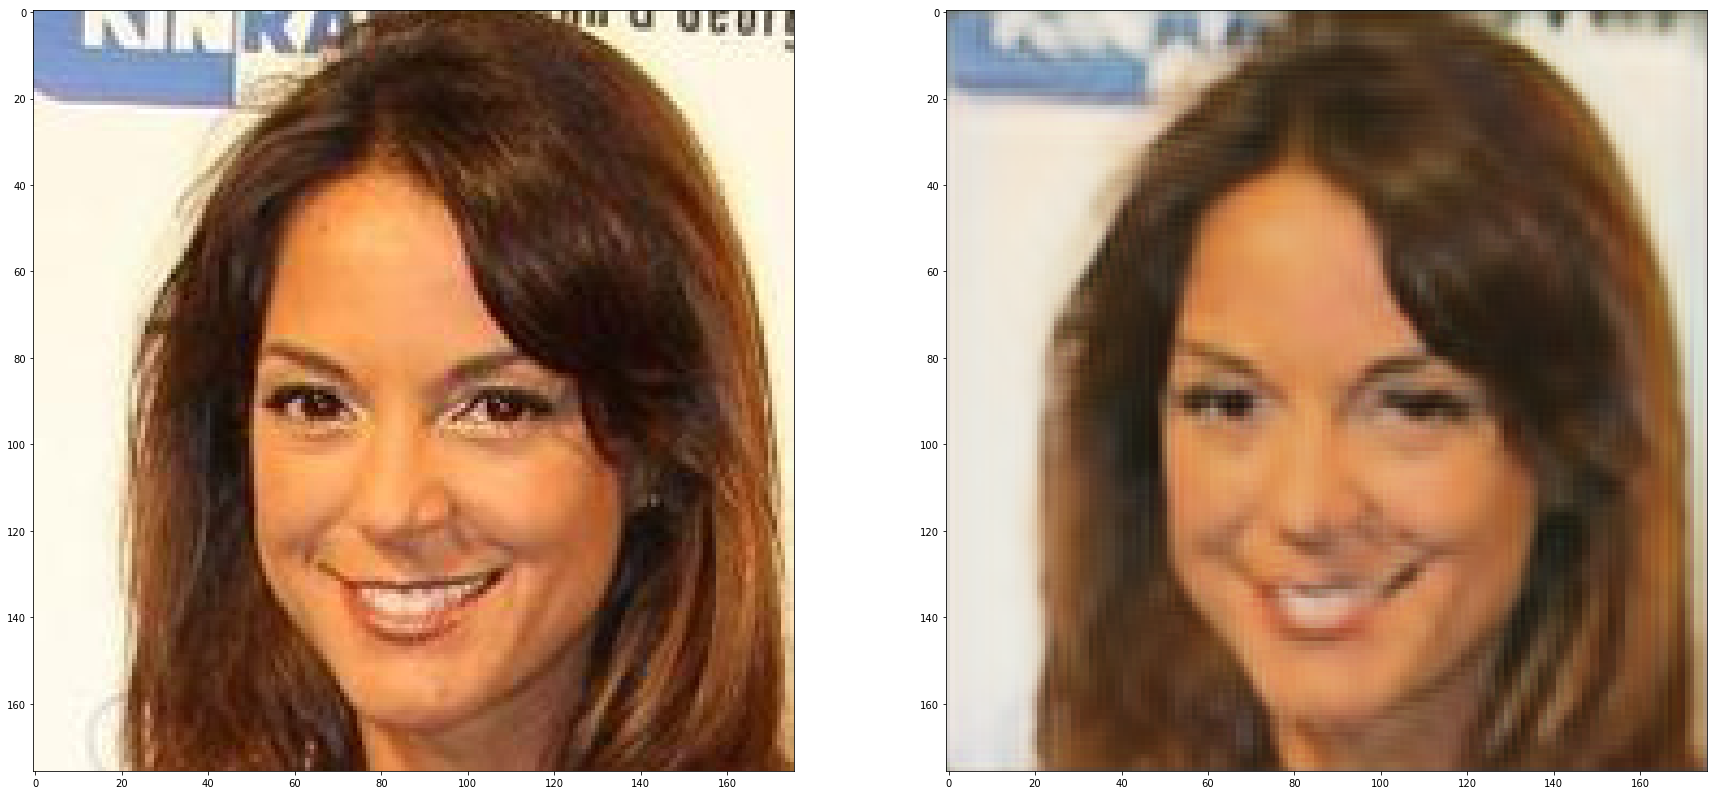

In [36]:
compare_pics(arr_test_hr[24].astype('uint8'),p[24].astype('uint8'))

# Let's Predict on the Prediction

In [37]:
new_upsampled_inp,new_upsampled_output = get_upsampling_model_4x(p[20:25])

In [38]:
new_up_model = Model(new_upsampled_inp,new_upsampled_output)
new_up_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 176, 176, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 176, 176, 64)  15616       input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_12 (BatchNorm (None, 176, 176, 64)  256         convolution2d_13[0][0]           
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 176, 176, 64)  0           batchnormalization_12[0][0]      
___________________________________________________________________________________________

In [39]:
new_new_up_model = Model(new_upsampled_inp, new_upsampled_output)
new_new_up_model.load_weights('./weights/'+'celba_2k.h5')

In [40]:
%time new_p = new_new_up_model.predict(p[20:30])


CPU times: user 4min 13s, sys: 5min 53s, total: 10min 6s
Wall time: 2min 40s


In [41]:
new_p.shape

(10, 704, 704, 3)

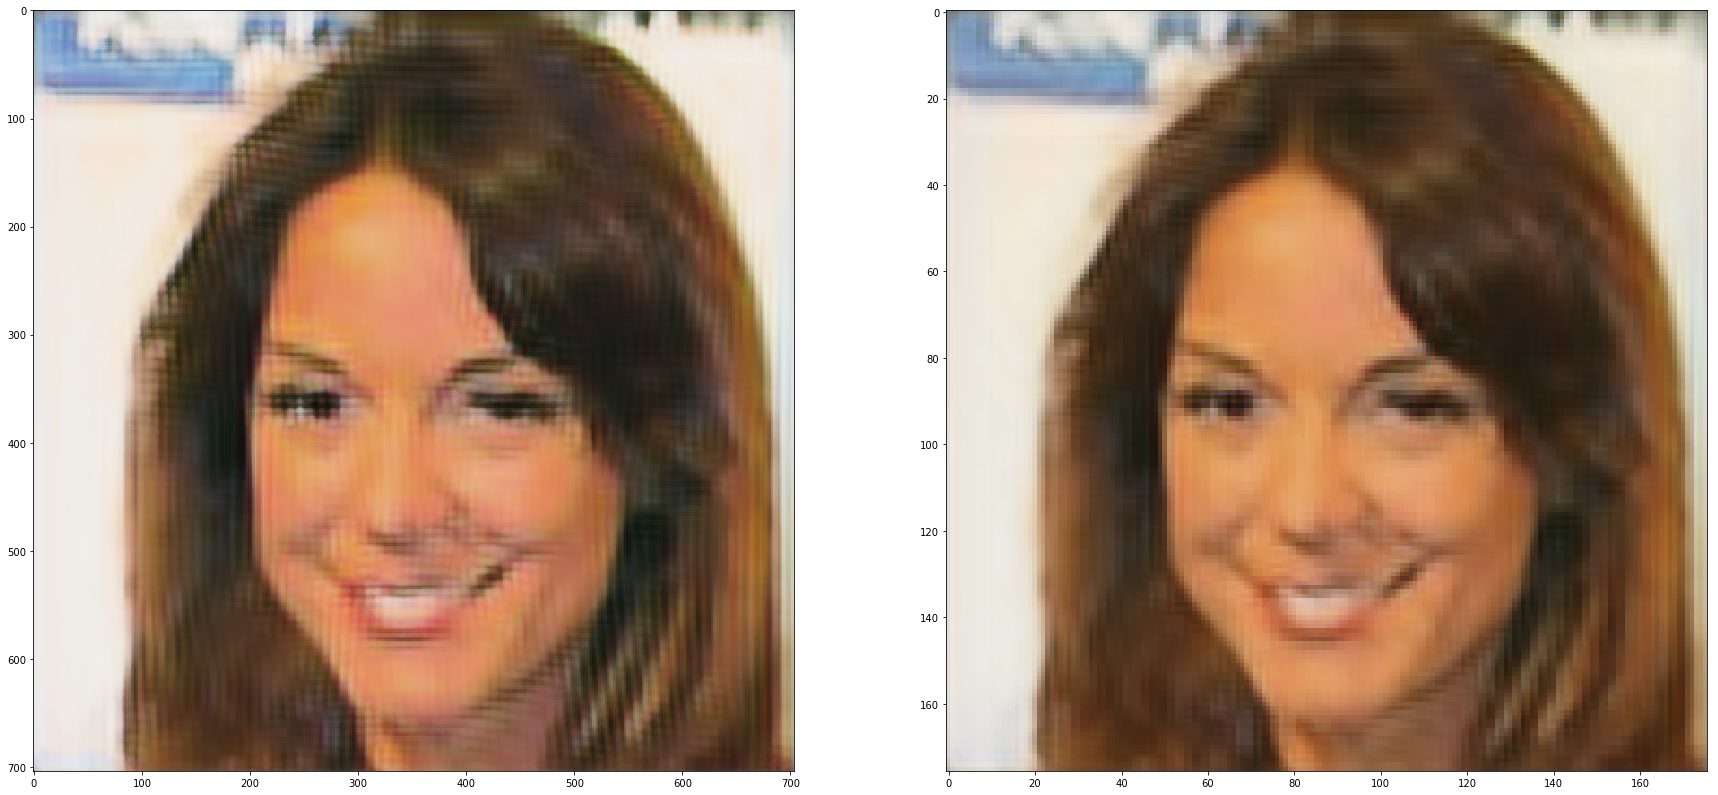

In [42]:
compare_pics(new_p[4].astype('uint8'),p[24].astype('uint8'))

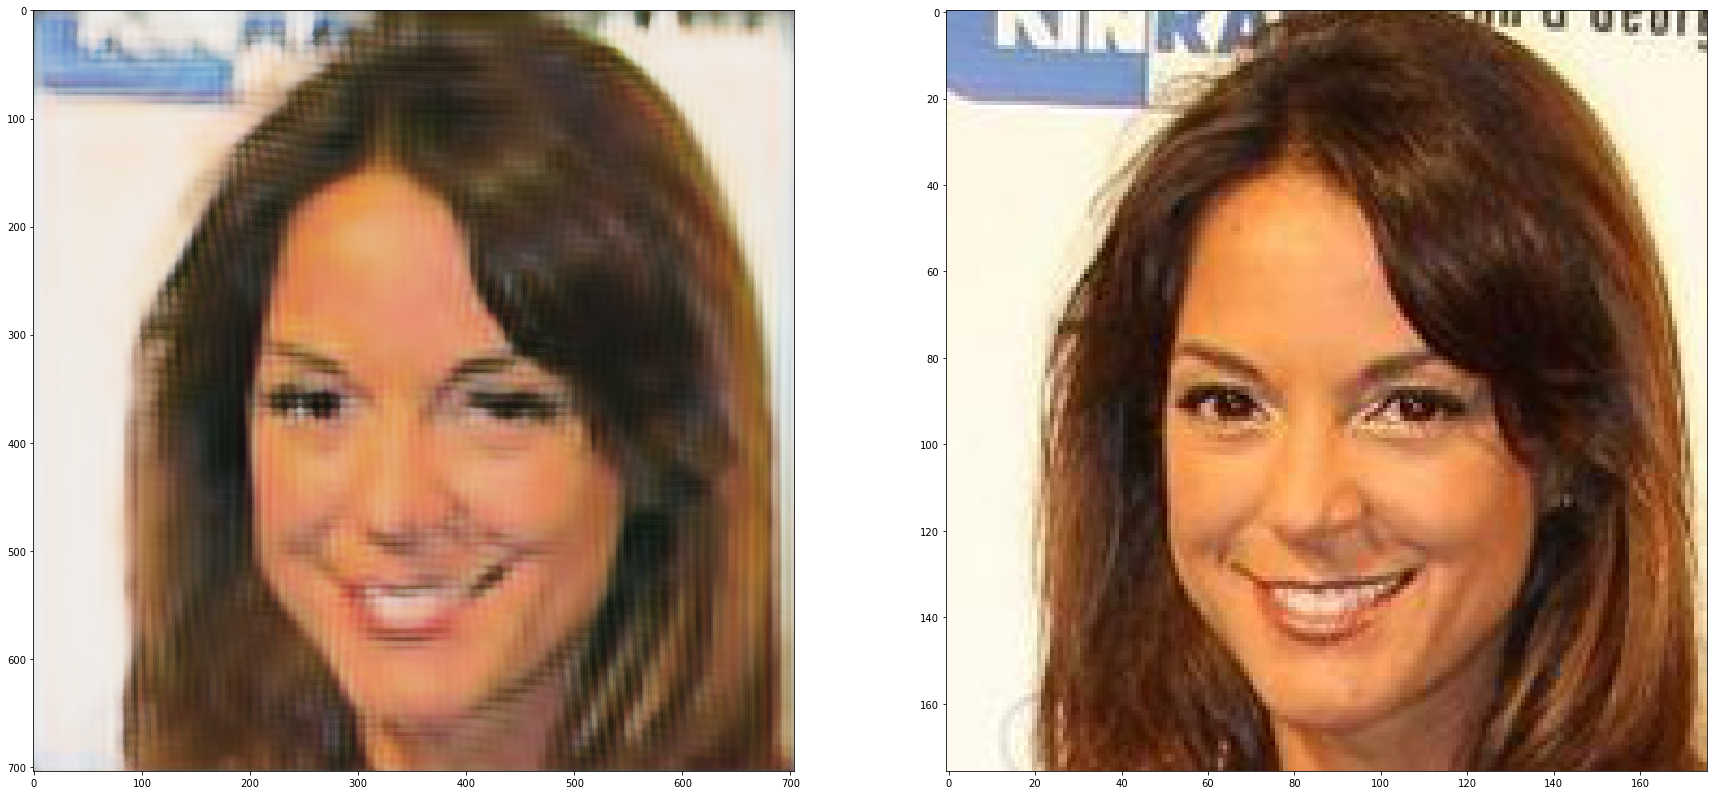

In [43]:
compare_pics(new_p[4].astype('uint8'),arr_test_hr[24].astype('uint8'))

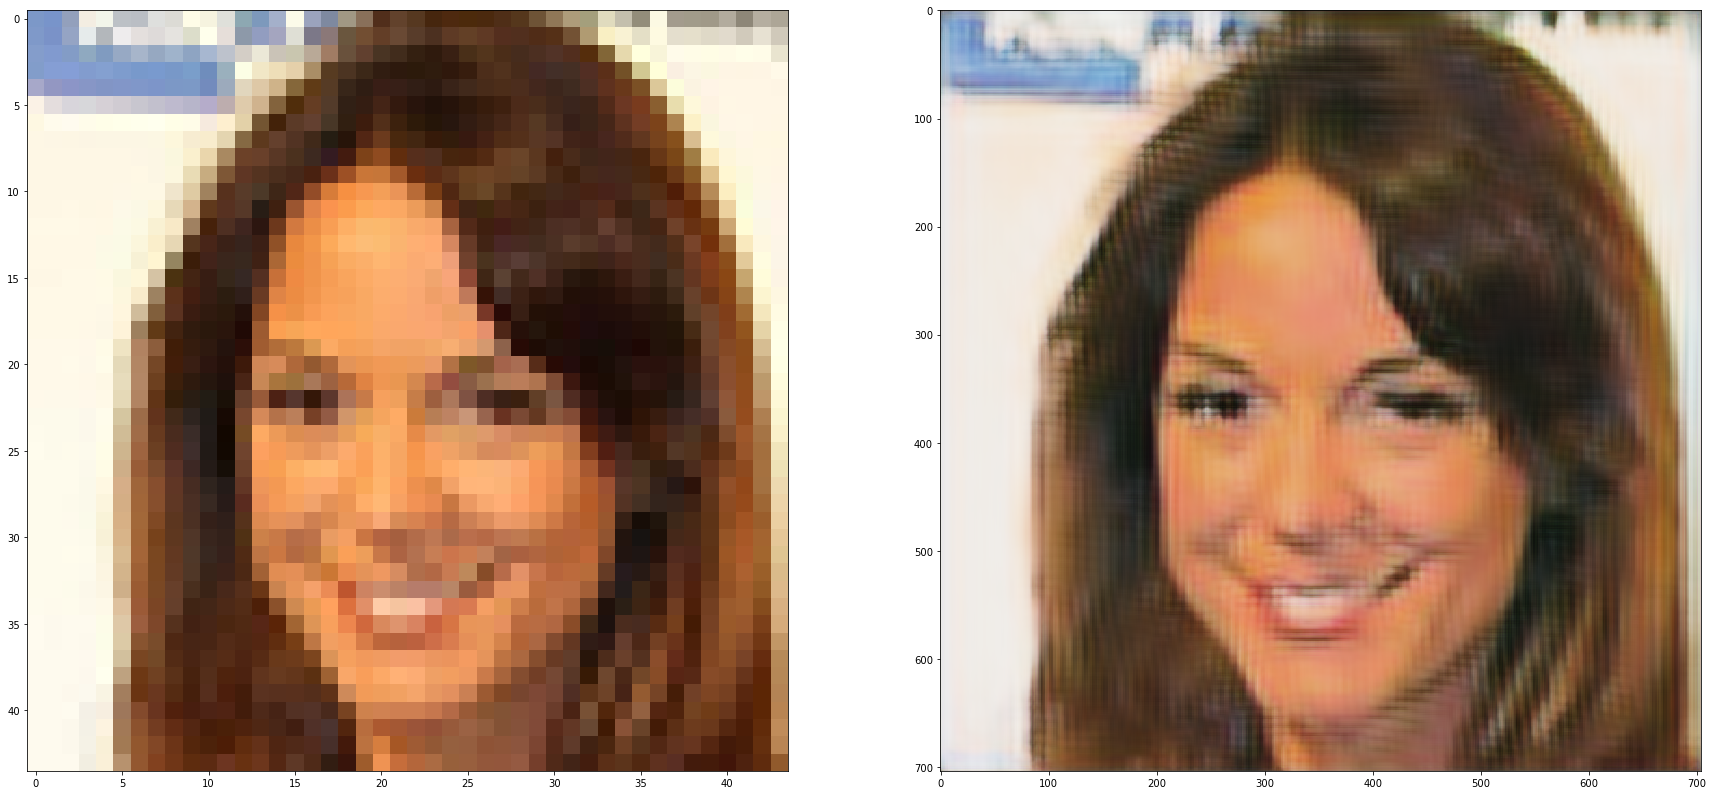

In [45]:
compare_pics(arr_test_lr[24].astype('uint8'),new_p[4].astype('uint8'))

### Credits

Papers: "Perceptual Losses for Real-Time Style Transfer and Super-Resolution" by Johnson, et.al
http://arxiv.org/abs/1603.08155

"A Neural Algorithm of Artistic Style" by Gatys et.al 
http://arxiv.org/abs/1508.06576v2

Code ideas inspired by Jermey Howard's SFData Institute Advanced Deep Learning Course 